# Práctica 2: Auto-codificadores

In [27]:
import os
from abc import ABC, abstractmethod
import torch
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


In [28]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print(f"Train: {len(train_data)} imágenes")
print(f"Test:  {len(test_data)} imágenes")



Train: 60000 imágenes
Test:  10000 imágenes


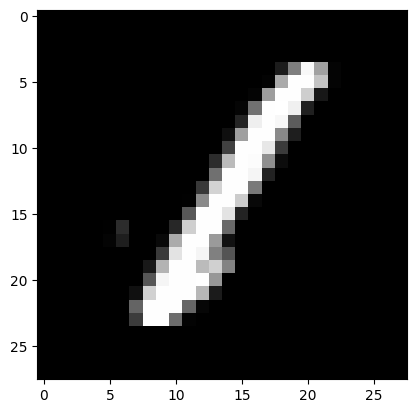

In [29]:


dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0].numpy().squeeze()

plt.imshow(image, cmap='gray')
plt.show()



In [30]:
#============================================================================
# Modelo AutoencoderConv (para Denoising)
# ============================================================================
class AutoencoderConv(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 28x28 -> 14x14 -> 7x7 -> 1x1
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7),
            nn.ReLU()
        )
        # Decoder: 1x1 -> 7x7 -> 14x14 -> 28x28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [31]:
# ============================================================================
#  Modelo SuperResolutionAutoencoder (MEJORADO para 7x7)
# ============================================================================
class SuperResolutionAutoencoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        assert input_size in (7, 14), "Solo 7x7 o 14x14"
        
        if input_size == 7:
            # Encoder MÁS POTENTE para imágenes 7x7 (64→128→256 canales)
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU()
            )
            # Decoder 7x7 → 28x28 (escala x4)
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
        else:  # 14x14
            # Encoder para imágenes 14x14
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU()
            )
            # Decoder 14x14 → 28x28 (escala x2)
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [32]:
# ============================================================================
# Factory para crear modelos
# ============================================================================
class ModelFactory:
    @staticmethod
    def create_denoising_autoencoder(device):
        model = AutoencoderConv().to(device)
        return model

    @staticmethod
    def create_super_resolution_autoencoder(device, input_size):
        model = SuperResolutionAutoencoder(input_size).to(device)
        return model



### Servicio de visualización (matriz 3×N)

In [33]:
# ============================================================================
#  Servicio de entrenamiento
# ============================================================================
class TrainerService:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train(self, dataloader, num_epochs, transform_input, transform_target):
        self.model.train()
        history = []
        for epoch in range(num_epochs):
            running_loss = 0.0
            for imgs, _ in dataloader:
                imgs = imgs.to(self.device)
                inputs = transform_input(imgs)
                targets = transform_target(imgs)
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item() * imgs.size(0)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            history.append(epoch_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.6f}")
        return history



In [34]:
# ============================================================================
# Servicio de visualización   
# ============================================================================
class VisualizationService:
    @staticmethod
    def show_triplet_grid(originals, corrupted, reconstructions, num_images=10, title=""):
        originals = originals[:num_images].cpu().numpy()
        corrupted = corrupted[:num_images].cpu().numpy()
        reconstructions = reconstructions[:num_images].cpu().detach().numpy()

        plt.figure(figsize=(num_images, 4))
        plt.suptitle(title, fontsize=16)

        for i in range(num_images):
            # Fila 1: originales
            plt.subplot(3, num_images, i + 1)
            plt.imshow(originals[i].squeeze(), cmap="gray", interpolation='nearest')
            plt.axis("off")
            if i == 0:
                plt.ylabel("Original", fontsize=11, rotation=0, labelpad=40)

            # Fila 2: degradadas
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(corrupted[i].squeeze(), cmap="gray", interpolation='nearest')
            plt.axis("off")
            if i == 0:
                plt.ylabel("Degradada", fontsize=11, rotation=0, labelpad=40)

            # Fila 3: reconstruidas
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(reconstructions[i].squeeze(), cmap="gray", interpolation='nearest')
            plt.axis("off")
            if i == 0:
                plt.ylabel("Reconstruida", fontsize=11, rotation=0, labelpad=40)

        plt.tight_layout()
        plt.show()


In [35]:
# ============================================================================
# Strategy para tareas (abstracta)
# ============================================================================
class AutoencoderTask(ABC):
    @abstractmethod
    def transform_input(self, imgs):
        pass

    @abstractmethod
    def transform_target(self, imgs):
        pass

    @abstractmethod
    def title(self):
        pass


## Tarea 1 Denoising

In [36]:
# ============================================================================
# Tarea de Denoising
# ============================================================================
class DenoisingTask(AutoencoderTask):
    def __init__(self, device, noise_std=0.4):
        self.device = device
        self.noise_std = noise_std

    def transform_input(self, imgs):
        noise = torch.randn_like(imgs) * self.noise_std
        noisy_imgs = torch.clamp(imgs + noise, 0.0, 1.0)
        return noisy_imgs.to(self.device)

    def transform_target(self, imgs):
        return imgs.to(self.device)

    def title(self):
        return f"Autoencoder de eliminación de ruido (σ={self.noise_std})"



### Tarea 2: Super–resolución 7×7 y 14×14 → 28×28
Aquí no se cambia el modelo; se cambia la “estrategia” de entrada/objetivo: se genera una versión 7×7 o 14×14 a partir de la 28×28, se reescala de vuelta a 28×28 (interpolación) y el autoencoder aprende a mapear esa imagen “borrosa” a la original.​



In [37]:
# ============================================================================
# Utilidad de downsample
# ============================================================================
def downsample_to_size(x, out_size):
    return torch.nn.functional.interpolate(
        x, size=(out_size, out_size), mode="bilinear", align_corners=False
    )



In [38]:
# ============================================================================
# Tarea de Super-resolución
# ============================================================================

class SuperResolutionTask(AutoencoderTask):
    def __init__(self, device, low_res_size, add_noise=False, noise_std=0.1):
        assert low_res_size in (7, 14)
        self.device = device
        self.low_res_size = low_res_size
        self.add_noise = add_noise
        self.noise_std = noise_std

    def transform_input(self, imgs):
        low = downsample_to_size(imgs, self.low_res_size)
        
        if self.add_noise:
            noise = torch.randn_like(low) * self.noise_std
            low = torch.clamp(low + noise, 0.0, 1.0)
        
        return low.to(self.device)

    def transform_target(self, imgs):
        return imgs.to(self.device)

    def title(self):
        noise_info = f" +ruido(σ={self.noise_std})" if self.add_noise else ""
        return f"Super-resolución ({self.low_res_size}x{self.low_res_size} → 28x28){noise_info}"


In [39]:
# ============================================================================
#  Entrenar DENOISING
# ============================================================================
print("\n" + "="*60)
print("[1/4] ENTRENANDO: Denoising")
print("="*60)

loss_fn = nn.MSELoss()

model_denoise = ModelFactory.create_denoising_autoencoder(device)
optimizer_denoise = torch.optim.Adam(model_denoise.parameters(), lr=1e-3, weight_decay=1e-5)
denoising_task = DenoisingTask(device, noise_std=0.4)
trainer_denoise = TrainerService(model_denoise, optimizer_denoise, loss_fn, device)

history_denoise = trainer_denoise.train(
    dataloader=train_loader,
    num_epochs=10,
    transform_input=denoising_task.transform_input,
    transform_target=denoising_task.transform_target
)



[1/4] ENTRENANDO: Denoising
Epoch 1/10 - Loss: 0.042593
Epoch 2/10 - Loss: 0.017771
Epoch 3/10 - Loss: 0.014599
Epoch 4/10 - Loss: 0.013181
Epoch 5/10 - Loss: 0.012200
Epoch 6/10 - Loss: 0.011662
Epoch 7/10 - Loss: 0.011250
Epoch 8/10 - Loss: 0.010979
Epoch 9/10 - Loss: 0.010770
Epoch 10/10 - Loss: 0.010590


In [ ]:
# ============================================================================
# Entrenar SUPER-RESOLUCIÓN 7x7 
# ============================================================================
print("\n" + "="*60)
print("[2/4] ENTRENANDO: Super-resolución 7x7")
print("="*60)

model_sr7 = ModelFactory.create_super_resolution_autoencoder(device, input_size=7)
optimizer_sr7 = torch.optim.Adam(model_sr7.parameters(), lr=1e-3, weight_decay=1e-5)
sr7_task = SuperResolutionTask(device, low_res_size=7, add_noise=False)
trainer_sr7 = TrainerService(model_sr7, optimizer_sr7, loss_fn, device)

history_sr7 = trainer_sr7.train(
    dataloader=train_loader,
    num_epochs=15,  # 15 epochs para mejor convergencia en 7x7
    transform_input=sr7_task.transform_input,
    transform_target=sr7_task.transform_target
)




[2/4] ENTRENANDO: Super-resolución 7x7 (sin ruido)
Epoch 1/15 - Loss: 0.112469
Epoch 2/15 - Loss: 0.112004
Epoch 3/15 - Loss: 0.112004
Epoch 4/15 - Loss: 0.112005
Epoch 5/15 - Loss: 0.103841
Epoch 6/15 - Loss: 0.028031
Epoch 7/15 - Loss: 0.023127
Epoch 8/15 - Loss: 0.021748
Epoch 9/15 - Loss: 0.020940
Epoch 10/15 - Loss: 0.020432
Epoch 11/15 - Loss: 0.020032
Epoch 12/15 - Loss: 0.019727
Epoch 13/15 - Loss: 0.019470
Epoch 14/15 - Loss: 0.019209
Epoch 15/15 - Loss: 0.019013


In [41]:
# ============================================================================
# Entrenar SUPER-RESOLUCIÓN 14x14 SIN ruido
# ============================================================================
print("\n" + "="*60)
print("[3/4] ENTRENANDO: Super-resolución 14x14 (sin ruido)")
print("="*60)

model_sr14_clean = ModelFactory.create_super_resolution_autoencoder(device, input_size=14)
optimizer_sr14_clean = torch.optim.Adam(model_sr14_clean.parameters(), lr=1e-3, weight_decay=1e-5)
sr14_task_clean = SuperResolutionTask(device, low_res_size=14, add_noise=False)
trainer_sr14_clean = TrainerService(model_sr14_clean, optimizer_sr14_clean, loss_fn, device)

history_sr14_clean = trainer_sr14_clean.train(
    dataloader=train_loader,
    num_epochs=10,
    transform_input=sr14_task_clean.transform_input,
    transform_target=sr14_task_clean.transform_target
)




[3/4] ENTRENANDO: Super-resolución 14x14 (sin ruido)
Epoch 1/10 - Loss: 0.007688
Epoch 2/10 - Loss: 0.001807
Epoch 3/10 - Loss: 0.001652
Epoch 4/10 - Loss: 0.001574
Epoch 5/10 - Loss: 0.001524
Epoch 6/10 - Loss: 0.001489
Epoch 7/10 - Loss: 0.001463
Epoch 8/10 - Loss: 0.001443
Epoch 9/10 - Loss: 0.001422
Epoch 10/10 - Loss: 0.001406


In [42]:
# ============================================================================
# Entrenar SUPER-RESOLUCIÓN 14x14 CON ruido
# ============================================================================
print("\n" + "="*60)
print("[4/4] ENTRENANDO: Super-resolución 14x14 (con ruido)")
print("="*60)

model_sr14_noisy = ModelFactory.create_super_resolution_autoencoder(device, input_size=14)
optimizer_sr14_noisy = torch.optim.Adam(model_sr14_noisy.parameters(), lr=1e-3, weight_decay=1e-5)
sr14_task_noisy = SuperResolutionTask(device, low_res_size=14, add_noise=True, noise_std=0.15)
trainer_sr14_noisy = TrainerService(model_sr14_noisy, optimizer_sr14_noisy, loss_fn, device)

history_sr14_noisy = trainer_sr14_noisy.train(
    dataloader=train_loader,
    num_epochs=10,
    transform_input=sr14_task_noisy.transform_input,
    transform_target=sr14_task_noisy.transform_target
)

print("\n" + "="*60)
print("ENTRENAMIENTO COMPLETADO")
print("="*60)




[4/4] ENTRENANDO: Super-resolución 14x14 (con ruido)
Epoch 1/10 - Loss: 0.112968
Epoch 2/10 - Loss: 0.112006
Epoch 3/10 - Loss: 0.112005
Epoch 4/10 - Loss: 0.112005
Epoch 5/10 - Loss: 0.112005
Epoch 6/10 - Loss: 0.112005
Epoch 7/10 - Loss: 0.099428
Epoch 8/10 - Loss: 0.009345
Epoch 9/10 - Loss: 0.008408
Epoch 10/10 - Loss: 0.007992

ENTRENAMIENTO COMPLETADO


## Visualizaciones


[1/4] Visualizando Denoising...


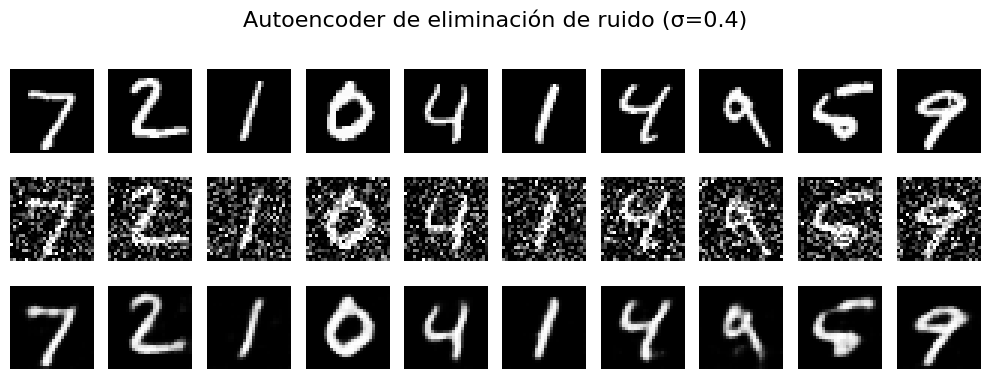

In [43]:
# ============================================================================
#  Visualizar DENOISING
# ============================================================================
print("\n[1/4] Visualizando Denoising...")

model_denoise.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    noisy = denoising_task.transform_input(imgs)
    recon = model_denoise(noisy)

VisualizationService.show_triplet_grid(
    originals=imgs,
    corrupted=noisy,
    reconstructions=recon,
    num_images=10,
    title=denoising_task.title()
)


[2/4] Visualizando Super-resolución 7x7...


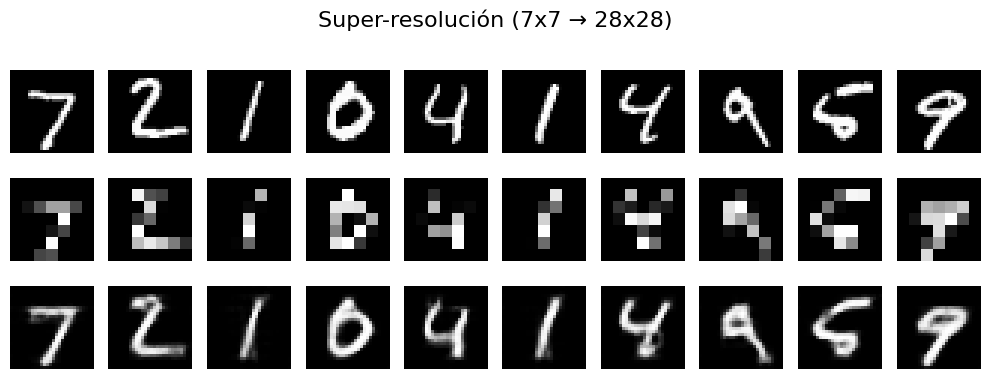

In [44]:
# ============================================================================
# CELDA 17: Visualizar SUPER-RESOLUCIÓN 7x7
# ============================================================================
print("[2/4] Visualizando Super-resolución 7x7...")

model_sr7.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    low7 = sr7_task.transform_input(imgs)
    recon7 = model_sr7(low7)

VisualizationService.show_triplet_grid(
    originals=imgs,
    corrupted=low7,
    reconstructions=recon7,
    num_images=10,
    title=sr7_task.title()
)




[3/4] Visualizando Super-resolución 14x14 (sin ruido)...


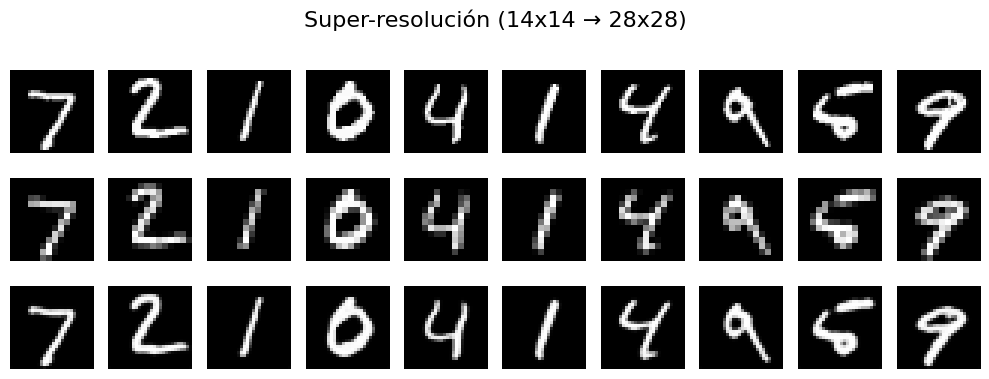

In [45]:
# ============================================================================
# Visualizar SUPER-RESOLUCIÓN 14x14 SIN ruido
# ============================================================================
print("[3/4] Visualizando Super-resolución 14x14 (sin ruido)...")

model_sr14_clean.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    low14_clean = sr14_task_clean.transform_input(imgs)
    recon14_clean = model_sr14_clean(low14_clean)

VisualizationService.show_triplet_grid(
    originals=imgs,
    corrupted=low14_clean,
    reconstructions=recon14_clean,
    num_images=10,
    title=sr14_task_clean.title()
)



[4/4] Visualizando Super-resolución 14x14 (con ruido)...


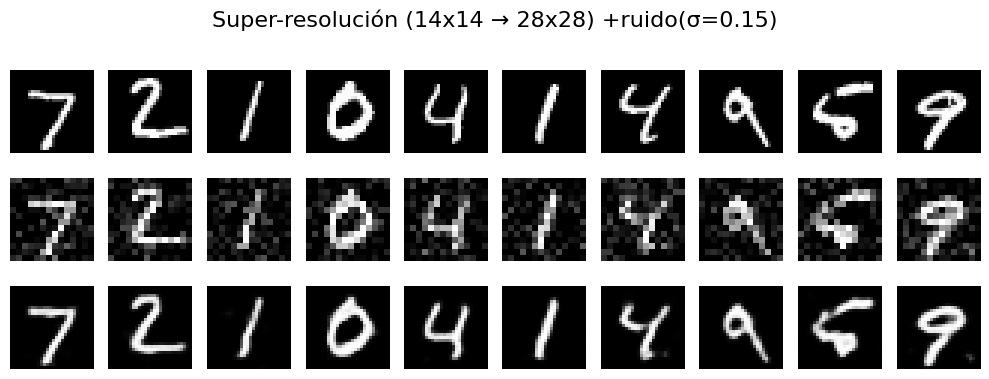

In [46]:
# ============================================================================
#  Visualizar SUPER-RESOLUCIÓN 14x14 CON ruido
# ============================================================================
print("[4/4] Visualizando Super-resolución 14x14 (con ruido)...")

model_sr14_noisy.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    low14_noisy = sr14_task_noisy.transform_input(imgs)
    recon14_noisy = model_sr14_noisy(low14_noisy)

VisualizationService.show_triplet_grid(
    originals=imgs,
    corrupted=low14_noisy,
    reconstructions=recon14_noisy,
    num_images=10,
    title=sr14_task_noisy.title()
)


## Graficas comparativas


Generando gráficas comparativas...


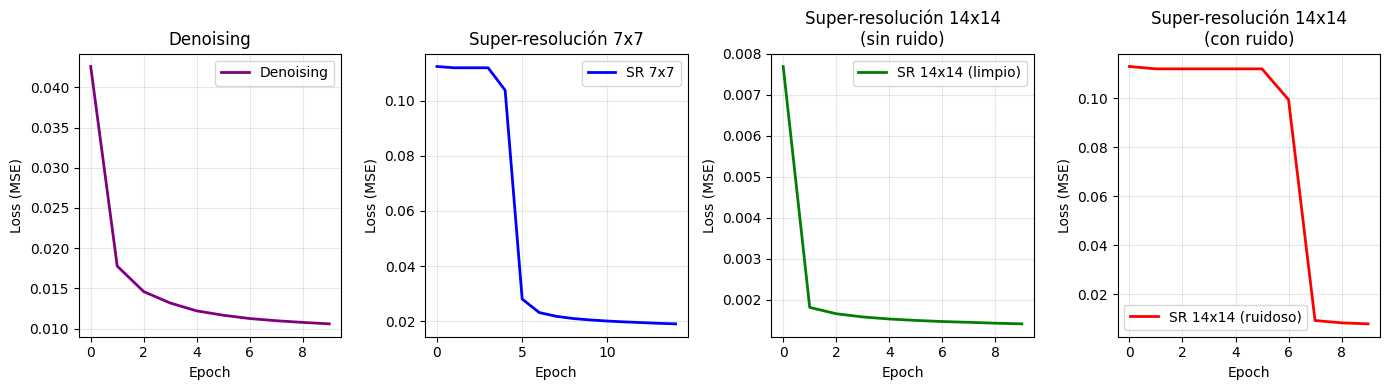

In [47]:
# ============================================================================
# Gráficas comparativas de pérdidas
# ============================================================================
print("\nGenerando gráficas comparativas...")

# Gráficas individuales
plt.figure(figsize=(14, 4))

plt.subplot(1, 4, 1)
plt.plot(history_denoise, label='Denoising', color='purple', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Denoising')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history_sr7, label='SR 7x7', color='blue', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Super-resolución 7x7')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history_sr14_clean, label='SR 14x14 (limpio)', color='green', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Super-resolución 14x14\n(sin ruido)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history_sr14_noisy, label='SR 14x14 (ruidoso)', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Super-resolución 14x14\n(con ruido)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()



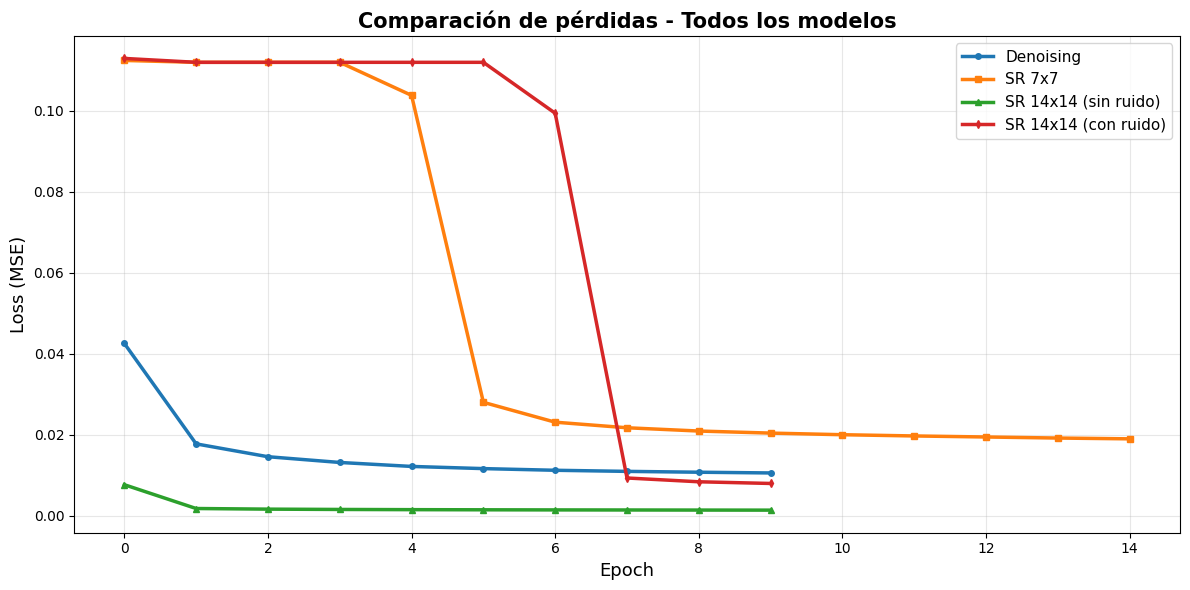

In [48]:
# ============================================================================
#  Gráfica comparativa conjunta
# ============================================================================
plt.figure(figsize=(12, 6))
plt.plot(history_denoise, label='Denoising', linewidth=2.5, marker='o', markersize=4)
plt.plot(history_sr7, label='SR 7x7', linewidth=2.5, marker='s', markersize=4)
plt.plot(history_sr14_clean, label='SR 14x14 (sin ruido)', linewidth=2.5, marker='^', markersize=4)
plt.plot(history_sr14_noisy, label='SR 14x14 (con ruido)', linewidth=2.5, marker='d', markersize=4)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss (MSE)', fontsize=13)
plt.title('Comparación de pérdidas - Todos los modelos', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Estadisticas finales


In [50]:
# ============================================================================
# CELDA 22: Estadísticas finales
# ============================================================================
print("\n" + "="*70)
print("ESTADÍSTICAS FINALES")
print("="*70)
print(f"{'Modelo':<35} {'Loss inicial':<15} {'Loss final':<15} {'Mejora':<10}")
print("-" * 70)
print(f"{'Denoising':<35} {history_denoise[0]:<15.6f} {history_denoise[-1]:<15.6f} {(1-history_denoise[-1]/history_denoise[0])*100:>6.2f}%")
print(f"{'SR 7x7 (15 epochs)':<35} {history_sr7[0]:<15.6f} {history_sr7[-1]:<15.6f} {(1-history_sr7[-1]/history_sr7[0])*100:>6.2f}%")
print(f"{'SR 14x14 (sin ruido)':<35} {history_sr14_clean[0]:<15.6f} {history_sr14_clean[-1]:<15.6f} {(1-history_sr14_clean[-1]/history_sr14_clean[0])*100:>6.2f}%")
print(f"{'SR 14x14 (con ruido)':<35} {history_sr14_noisy[0]:<15.6f} {history_sr14_noisy[-1]:<15.6f} {(1-history_sr14_noisy[-1]/history_sr14_noisy[0])*100:>6.2f}%")
print("="*70)






ESTADÍSTICAS FINALES
Modelo                              Loss inicial    Loss final      Mejora    
----------------------------------------------------------------------
Denoising                           0.042593        0.010590         75.14%
SR 7x7 (15 epochs)                  0.112469        0.019013         83.10%
SR 14x14 (sin ruido)                0.007688        0.001406         81.72%
SR 14x14 (con ruido)                0.112968        0.007992         92.93%
